## SINDy Predator-prey

In [1]:
import numpy as np
import pysindy as ps
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from my_handy_functions import *

In [44]:
def time_plot(t, x, main_str):
    plt.plot(t, x, label=['x', 'y'])
    plt.xlabel('t')
    plt.ylabel('x, y')
    plt.legend()
    plt.title(main_str)
    plt.show()

def phase_plot(x, main_str):
    plt.plot(x[:,0], x[:,1])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(main_str)
    plt.show()

def get_model():
    model = ps.SINDy(
    differentiation_method = ps.FiniteDifference(order=2),
        feature_library = ps.PolynomialLibrary(degree=3),
        optimizer = ps.STLSQ(threshold=0.2),
        feature_names=["x", "y"]
    )
    return(model)

def comparison_plot(x, sim, main_str):
    plt.plot(x[0,0], x[0,1], "ro", label="Initial condition", alpha=0.6, markersize=8)
    plt.plot(x[:,0], x[:,1], "b", label="Exact solution", alpha=0.4, linewidth=1)
    plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(main_str)
    plt.show()

def get_weak_model(t, num_steps, dt):
    library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
    library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

    ode_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        spatiotemporal_grid=t,
        K=num_steps,
        H_xt=dt/2
    )

    optimizer = ps.SR3(threshold=0.05, thresholder="l1", max_iter=1000, normalize_columns=True, tol=1e-1)

    model = ps.SINDy(feature_library=ode_lib, feature_names=["x","y"], optimizer=optimizer)
    return(model)

In [3]:
p=[1, 2, 3, 4] # Predator-prey parameters
t_start = 0
t_end = 90
num_steps = 1000

# ODE
def predator_prey(t, x, p=p):
    return [p[0] * x[0] - p[1] * x[0] * x[1], p[2] * x[0] * x[1] - p[3] * x[1]]

integrator_keywords = {'method':'LSODA', 'atol':1e-10, 'rtol':1e-12}

Clean data, normal SINDy

In [4]:
dt = (t_end-t_start)/num_steps
t = np.arange(t_start, t_end, dt)
t_span = (t_start, t_end)

x0 = [1, 2]
x = solve_ivp(predator_prey, t_span, x0, t_eval=t, **integrator_keywords).y.T

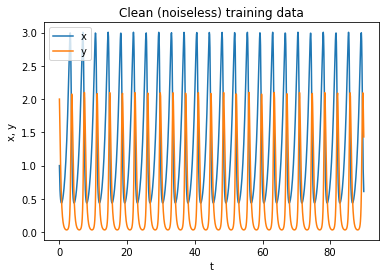

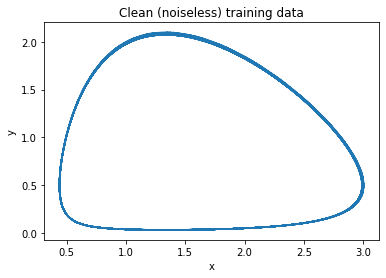

In [5]:
title = "Clean (noiseless) training data"
time_plot(t, x, title)
phase_plot(x, title)

In [6]:
model = get_model()
model.fit(x, t=dt)
model.print()

(x)' = 0.983 x + -1.965 x y
(y)' = -3.893 y + 2.919 x y


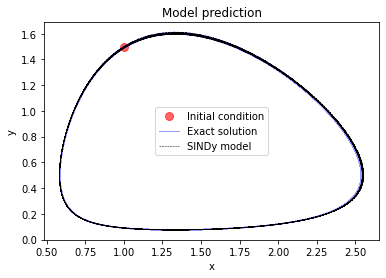

In [7]:
x0_test = [1, 1.5]
t_test = t
t_span_test = t_span
x_test = solve_ivp(predator_prey, t_span_test, x0_test, t_eval=t_test, **integrator_keywords).y.T

sim = model.simulate(x0_test, t=t_test)
comparison_plot(x_test, sim, "Model prediction")

Noisy data, normal SINDy

In [8]:
sd = 0.02
x_noisy = lognormal_noisify(x, sd)

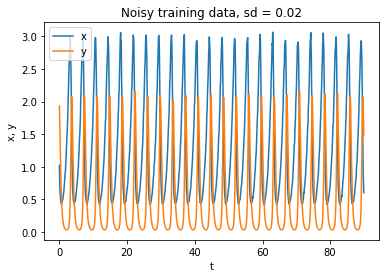

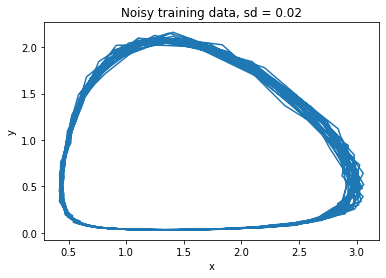

In [9]:
title = f'Noisy training data, sd = {sd}'
time_plot(t, x_noisy, title)
phase_plot(x_noisy, title)

In [10]:
model_noisy = get_model()
model_noisy.fit(x_noisy, t=dt)
model_noisy.print()

(x)' = 1.029 x + 0.584 y + -3.798 x y + 0.440 x^2 y + 0.361 x y^2
(y)' = -3.866 y + 2.901 x y


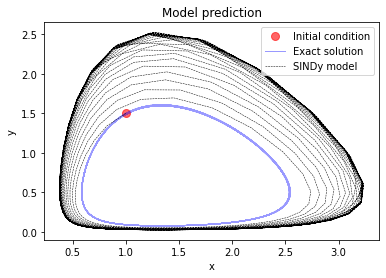

In [11]:
sim_noisy = model_noisy.simulate(x0_test, t=t_test)
x_noisy_test = solve_ivp(predator_prey, t_span_test, x0_test, t_eval=t_test, **integrator_keywords).y.T
comparison_plot(x_noisy_test, sim_noisy, "Model prediction")

Clean data, weak SINDy

In [50]:
weak_model = get_weak_model(t, num_steps, dt)
weak_model.fit(x, t=dt)
print_result(weak_model, ["x", "y"])

Feature library:
['x', 'y', 'xx', 'yy', 'xy']
STLSQ model:
(x)' = 1.002 x + -1.999 xy
(y)' = -4.001 y + 2.994 xy


In [13]:
sim = weak_model.simulate(x0_test, t=t_test)
comparison_plot(x_test, sim, "Model prediction")

ValueError: cannot reshape array of size 2 into shape (1,1000,2)

Noisy data, weak SINDy

In [38]:
weak_model_noisy = get_weak_model(t, 20)
weak_model_noisy.fit(x_noisy, t=dt)
print_result(weak_model_noisy, ["x", "y"])

TypeError: get_weak_model() missing 1 required positional argument: 'dt'

In [ ]:
sim = weak_model_noisy.simulate(x0_test, t=t_test)
comparison_plot(x_test, sim, "Model prediction")

ValueError: cannot reshape array of size 2 into shape (1,1000,2)